# Quality Evaluation on ImageNet1k

This notebooks allows to run the quality evaluation of any classsification model from [**CoreML Model Zoo**](https://github.com/vladimir-chernykh/coreml-model-zoo) on **ImageNet1k** data ([ILSVRC](http://www.image-net.org/challenges/LSVRC/)).

The **validation set** is taken because it is almost never included into the training set of the specific model and has never changed since 2012.

# Imports

In [1]:
import os
import glob
import importlib

import xml.etree.ElementTree as ET

from tqdm.notebook import tqdm

import numpy as np
from joblib import Parallel, delayed

from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import coremltools

Define a function to dynamically import object from module

In [2]:
def dynamic_import(abs_module_path, class_name):
    module_object = importlib.import_module(abs_module_path)

    target_class = getattr(module_object, class_name)

    return target_class

# Model

Specify model name and version

In [3]:
model_name = "mobilenet_v2"
model_spec = "mobilenet_v2_0.35_96_keras_applications"

Load CoreML model

In [4]:
model = coremltools.models.MLModel(f"../../vision/classification/{model_name}/models/{model_spec}.mlmodel")

# Data

Read ImageNet classes info

In [5]:
with open("./imagenet1k_classes.txt") as f:
    classes_coreml = f.readlines()
classes_coreml = np.array([c.rstrip('\n') for c in classes_coreml])
classes_coreml_dict = {c:i for i, c in enumerate(classes_coreml)}

ImageNet dataset reader

In [6]:
class DatasetImagenet(Dataset):
    
    def __init__(self, root, split, classes_mapping, transform=None):

        self.transform = transform
        self.root = root

        with open(classes_mapping) as fp:
            _temp = [line.rstrip('\n').split(" ", maxsplit=1) for line in fp]
            self.classnames_mapping = dict(_temp)
            self.classids_mapping = {wnid[0]: idd for idd, wnid in enumerate(_temp)}

        annotation_files = sorted(glob.glob(os.path.join(root, f"Annotations/CLS-LOC/{split}/*.xml")))

        self.image_files = np.array([file.replace("/Annotations/", "/Data/").rstrip(".xml") + ".JPEG" 
                                     for file in annotation_files])

        self.wnids = Parallel(n_jobs=8)(delayed(self._annotation_wnids_reader)(file) 
                                         for file in annotation_files)
        self.wnids = np.array([item[0] for item in self.wnids])
        self.classnames = np.array([self.classnames_mapping[wnid] for wnid in self.wnids])
        self.classids = np.array([self.classids_mapping[wnid] for wnid in self.wnids])

    @staticmethod
    def _annotation_wnids_reader(annotation_file):
        xmltree = ET.parse(annotation_file)
        objects = xmltree.findall("object")
        result = []
        for object_iter in objects:
            bndbox = object_iter.find("name")
            result.append(bndbox.text)
        return result

    def __len__(self):
        return len(self.classids)

    def __getitem__(self, idx):

        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        label = self.classids[idx]

        return image, label

All the preprocessing steps are embedded into the network. All one has to do outside is resizing.

Different models are trained in different frameworks and settings each of which requires a little bit different resizing options to fully repeat the quality.

Load resizing transformation suitable exactly for the model of interest:

In [7]:
%cd ../..
transform_resize_dict = dynamic_import(
    f"vision.classification.{model_name}.evaluation_utils.resize_utils", 
    "transform_resize_dict")
%cd tools/evaluation
transform_coreml = transform_resize_dict[model_spec]

/Users/vovacher/Dropbox/coreml-zoo/coreml-model-zoo
/Users/vovacher/Dropbox/coreml-zoo/coreml-model-zoo/tools/evaluation


Create `Dataset` object with ImageNet dataset. It might take around 10 seconds because all the `xml`s with annotations are parsed.

In [8]:
dataset = DatasetImagenet(root="/Users/vovacher/Downloads/ILSVRC", 
                          split="val", 
                          classes_mapping="/Users/vovacher/Downloads/ILSVRC/LOC_synset_mapping.txt", 
                          transform=transform_coreml)

Data sample example

In [9]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=96x96 at 0x7FDFF3B01910>, 65)

More examples visualized

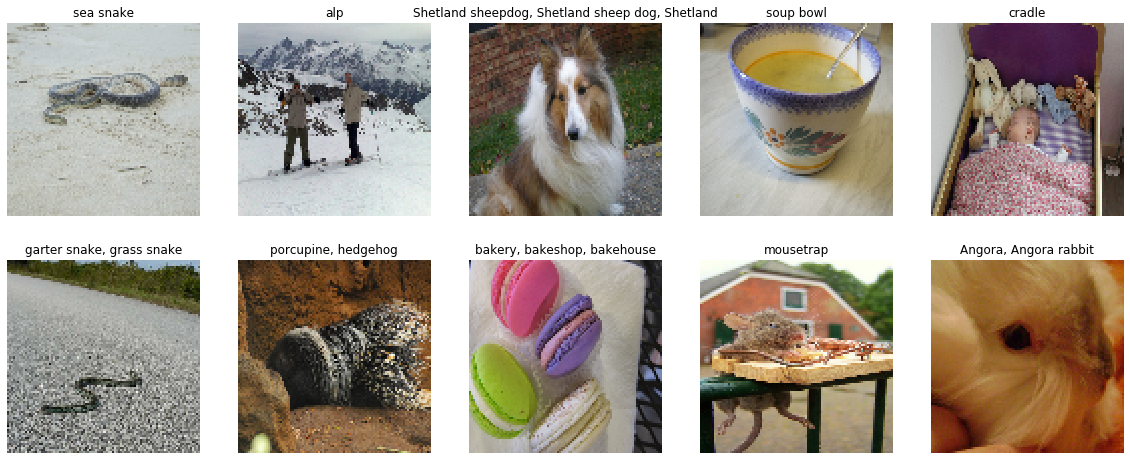

In [10]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(dataset[i][0])
    plt.axis("off")
    plt.title(classes_coreml[dataset[i][1]])

# Evaluation

Define `DataLoader` which is able to sample from `Dataset` efficiently.

In [11]:
def custom_collate_fn(batch):
    return {"input_1": batch[0][0], "target": batch[0][1]}
dataloader = DataLoader(dataset=dataset, 
                        batch_size=1, 
                        num_workers=4, 
                        collate_fn=custom_collate_fn)

Evaluate the model on **ILSVRC 2012 validation** data

In [10]:
y_true = []
y_preds_proba = []
for data in tqdm(dataloader):
    y_true.append(data["target"])
    _pred = model.predict(data=data, useCPUOnly=True)
    y_preds_proba.append(_pred)
y_true = np.array(y_true)
y_preds_proba = np.array(y_preds_proba)

Transform predictions from class names into class numbers to compare with ground truth

In [18]:
y_preds_proba_ids = []
for i in tqdm(range(len(y_preds_proba))):
    _outs = y_preds_proba[i]["output_1"]
    y_preds_proba_ids.append(np.zeros(len(_outs)))
    for k, v in _outs.items():
        y_preds_proba_ids[-1][classes_coreml_dict[k]] = v
y_preds_proba_ids = np.array(y_preds_proba_ids)

# Results

Top-1 Accuracy

In [19]:
top1_acc = (y_true == np.argmax(y_preds_proba_ids, axis=1)).mean()
top1_acc

0.45422

Top-5 Accuracy

In [20]:
_top5 = np.argsort(y_preds_proba_ids, axis=1)[..., -5:]
top5_acc = np.mean([y_true[i] in _top5[i] for i in range(len(_top5))])
top5_acc

0.70332